In [4]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files

# VEST Florida Validation

## Load and Examine VEST File

In [5]:
#Load the file
vest_fl = gp.read_file("./raw-from-source/fl_2018/fl_2018.shp")

#Take look at the file, looks like "Pct_std" is the unique identifier column
print(vest_fl.head())

#Look whether all the values are unique
#All the values seem to be unique, except for "PAL00NP" - which occurs 67 times
print(vest_fl["Pct_std"].value_counts())

#Pattern for unique identifier seems to be county + at least four digit "Precnct"
#Check if there are any that don't match this (might be helpful to know)
vest_fl["check"]=vest_fl["County"]+vest_fl["Precnct"].astype(str).str.zfill(4)
vest_fl["confirm"]=vest_fl["Pct_std"]==vest_fl["check"]

#It looks like there are 5 rows that don't match this pattern, keep this in mind for later
print(vest_fl[vest_fl["confirm"]==False].shape)
print(vest_fl[vest_fl["confirm"]==False])

#Grab the CRS, as I will need this for later
#vest_fl["geometry"]=vest_fl.buffer(0)
vest_proj = vest_fl.crs

   Pct_std County Precnct  G18USSRSCO  G18USSDNEL  G18GOVRDES  G18GOVDGIL  \
0  ALA0001    ALA      01         532         372         544         357   
1  ALA0002    ALA      02         717         662         739         622   
2  ALA0003    ALA      03        1541        1192        1592        1123   
3  ALA0004    ALA      04        1320         767        1372         688   
4  ALA0005    ALA      05         433        1545         438        1525   

   G18GOVORIC  G18GOVONPA  G18ATGRMOO  ...  G18A09NO  G18A10YES  G18A10NO  \
0           2           7         563  ...       358        500       367   
1          12          13         762  ...       552        743       563   
2          13          16        1646  ...      1021       1476      1096   
3           8          17        1408  ...       897       1169       811   
4           7          11         483  ...       384        631      1178   

   G18A11YES  G18A11NO  G18A12YES  G18A12NO  G18A13YES  G18A13NO  \
0     

In [6]:
vest_fl.shape

(6073, 43)

In [7]:
#Look at the VEST unique identifier column
print(vest_fl.columns)

Index(['Pct_std', 'County', 'Precnct', 'G18USSRSCO', 'G18USSDNEL',
       'G18GOVRDES', 'G18GOVDGIL', 'G18GOVORIC', 'G18GOVONPA', 'G18ATGRMOO',
       'G18ATGDSHA', 'G18ATGOSIS', 'G18CFORPAT', 'G18CFODRIN', 'G18AGRRCAL',
       'G18AGRDFRI', 'G18A01YES', 'G18A01NO', 'G18A02YES', 'G18A02NO',
       'G18A03YES', 'G18A03NO', 'G18A04YES', 'G18A04NO', 'G18A05YES',
       'G18A05NO', 'G18A06YES', 'G18A06NO', 'G18A07YES', 'G18A07NO',
       'G18A09YES', 'G18A09NO', 'G18A10YES', 'G18A10NO', 'G18A11YES',
       'G18A11NO', 'G18A12YES', 'G18A12NO', 'G18A13YES', 'G18A13NO',
       'geometry', 'check', 'confirm'],
      dtype='object')


## Load Precinct-level Elections Data

Link to data definitions and field codes  
https://fldoswebumbracoprod.blob.core.windows.net/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [8]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/precinctlevelelectionresults2018gen")

In [9]:
#Check that all files have the same number of columns
for i in all_files:
    ref = "./raw-from-source/precinctlevelelectionresults2018gen/"
    file_ref = ref+i
    file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
    print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

(932, 19)
(1456, 19)
(7469, 19)
(1440, 19)
(1168, 19)
(8401, 19)
(3620, 19)
(1392, 19)
(3876, 19)
(22002, 19)
(9861, 19)
(1573, 19)
(2436, 19)
(1740, 19)
(14462, 19)
(1120, 19)
(1858, 19)
(14575, 19)
(1130, 19)
(1511, 19)
(2892, 19)
(1824, 19)
(5795, 19)
(9586, 19)
(1035, 19)
(4604, 19)
(5936, 19)
(110823, 19)
(13776, 19)
(69667, 19)
(19191, 19)
(3759, 19)
(1060, 19)
(2804, 19)
(8109, 19)
(4715, 19)
(1188, 19)
(36580, 19)
(18563, 19)
(17815, 19)
(1740, 19)
(2713, 19)
(1232, 19)
(2576, 19)
(12023, 19)
(908, 19)
(1595, 19)
(26353, 19)
(545, 19)
(4920, 19)
(927, 19)
(5400, 19)
(26955, 19)
(2786, 19)
(928, 19)
(888, 19)
(1560, 19)
(3990, 19)
(8029, 19)
(1182, 19)
(3402, 19)
(97063, 19)
(59816, 19)
(15186, 19)
(8052, 19)
(9236, 19)
(1344, 19)


In [10]:
#Create a dataframe with the txt files
li = []
for i in all_files:
    ref = "./raw-from-source/precinctlevelelectionresults2018gen/"
    file_ref = ref+i
    file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
    li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(743093, 19)


### Clean Elections Data

In [11]:
#Filter down to the relevant races
office_List = ['United States Senator','Governor','Attorney General','Chief Financial Officer','Commissioner of Agriculture','Amendment No. 1: Increased Homestead Property Tax Exemption','Amendment No. 2: Limitations on Property Tax Assessments','Amendment No. 3: Voter Control of Gambling in Florida','Amendment No. 4: Voting Restoration Amendment','Amendment No. 5: Supermajority Vote Required to Impose, Authorize, or Raise State Taxes or Fees','Amendment No. 6: Rights of Crime Victims; Judges','Amendment No. 7: First Responder and Military Member Survivor Benefits; Public Colleges and Universities','Amendment No. 9: Prohibits Offshore Oil and Gas Drilling; Prohibits Vaping in Enclosed Indoor Workplaces','Amendment No. 10: State and Local Government Structure and Operation','Amendment No. 11: Property Rights; Removal of Obsolete Provision; Criminal Statutes','Amendment No. 12: Lobbying and Abuse of Office by Public Officers','Amendment No. 13: Ends Dog Racing']
filtered_frame=frame[frame[11].isin(office_List)]

#Filter out unused columns
filtered_frame = filtered_frame.drop(columns=[1,2,3,4,8,9,10,12,13],axis=1)

#Filter out Senator WriteinVotes and OverVotes and UnderVotes
no_count = ['WriteinVotes','OverVotes','UnderVotes']
filtered_frame = filtered_frame[~filtered_frame[14].isin(no_count)]

In [12]:
#From taking a look at the VEST file, this is the way to create the unique ID 

#Make the precinct column at least 4 digits
filtered_frame[5]=filtered_frame[5].astype(str)
filtered_frame["modified_pre"]=filtered_frame[5].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["Pct_std"]=filtered_frame[0]+filtered_frame["modified_pre"]

### Pivot Elections Data

In [13]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2018 = pd.pivot_table(filtered_frame, values=[18], index=["Pct_std"],columns=[11,14],aggfunc=sum)

In [14]:
#Clean up index
pivoted_2018 = pivoted_2018.reset_index()
pd.set_option('display.max_columns', None)
#display(pivoted_2018)

#Rename the columns
pivoted_2018.columns=['Pct_std','G18A10NO','G18A10YES','G18A11NO','G18A11YES','G18A12NO','G18A12YES','G18A13NO','G18A13YES','G18A01NO','G18A01YES',
                      'G18A02NO','G18A02YES', 'G18A03NO','G18A03YES','G18A04NO','G18A04YES','G18A05NO','G18A05YES',
                      'G18A06NO', 'G18A06YES','G18A07NO', 'G18A07YES','G18A09NO','G18A09YES',
                      'G18ATGRMOO', 'G18ATGOSIS','G18ATGDSHA','G18CFODRIN','G18CFORPAT', 'G18AGRRCAL','G18AGRDFRI', 
                       'G18GOVRDES','G18GOV_to_add1','G18GOV_to_add2','G18GOVDGIL','G18GOVORIC','G18GOV_to_add3','G18USSDNEL','G18USSRSCO']

#Fix governors results (they count all the no party candidates together)
pivoted_2018['G18GOVONPA']=pivoted_2018['G18GOV_to_add1']+pivoted_2018['G18GOV_to_add2']+pivoted_2018['G18GOV_to_add3']

In [15]:
#Recreate the county code
pivoted_2018["County"]=pivoted_2018["Pct_std"].str[0:3]

#Check how it looks
#print(pivoted_2018.head())
pivoted_2018.shape


(5999, 42)

All in all there are 5,999 rows in the precinct election results dataframe. The next step is to merge these precincts with the shapefiles.

## Load Shapefiles

The documentation mentions 4 different sources for the shapefiles:

1) Florida department of state (16 counties)  
2) 2016 VEST shapefile (17 counties)  
3) U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release (18 counties)  
4) Counties themselves (14 counties)  

67 total counties in FL, sources for 65 listed here.  

2 remaining counties are:  Columbia, Duval  

From an email conversation w/ Brian Amos (brianamos@gmail.com) on 01/13/21, I learned that:  
    "Columbia and Duval were sent from their respective SOE offices"  
    "FL DOS shapefiles were a records request"  
    
So, there are actually 16 counties where shapefiles were received from the Counties themselves

#### Resource: county names and three letter codes sheet**
  
['HOL' 'LEV' 'STL' 'HAR' 'CAL' 'ALA' 'HER' 'WAK' 'MON' 'POL' 'OSC' 'JAC'
 'WAL' 'DES' 'PAS' 'DIX' 'JEF' 'MRN' 'GIL' 'TAY' 'GAD' 'SUW' 'STJ' 'SEM'
 'BAK' 'SAN' 'OKA' 'PAL' 'SAR' 'BRO' 'BRE' 'CIT' 'GUL' 'HIG' 'MAN' 'IND'
 'MAD' 'PIN' 'LEO' 'LEE' 'NAS' 'FLA' 'OKE' 'CLM' 'LAK' 'UNI' 'BRA' 'DUV'
 'LAF' 'BAY' 'FRA' 'CLA' 'ORA' 'SUM' 'LIB' 'HAM' 'GLA' 'PUT' 'CLL' 'HEN'
 'MRT' 'DAD' 'HIL' 'VOL' 'CHA' 'ESC' 'WAS']  
 
['Holmes' 'Levy' 'St. Lucie' 'Hardee' 'Calhoun' 'Alachua' 'Hernando'
 'Wakulla' 'Monroe' 'Polk' 'Osceola' 'Jackson' 'Walton' 'Desoto' 'Pasco'
 'Dixie' 'Jefferson' 'Marion' 'Gilchrist' 'Taylor' 'Gadsden' 'Suwannee'
 'St. Johns' 'Seminole' 'Baker' 'Santa Rosa' 'Okaloosa' 'Palm Beach'
 'Sarasota' 'Broward' 'Brevard' 'Citrus' 'Gulf' 'Highlands' 'Manatee'
 'Indian River' 'Madison' 'Pinellas' 'Leon' 'Lee' 'Nassau' 'Flagler'
 'Okeechobee' 'Columbia' 'Lake' 'Union' 'Bradford' 'Duval' 'Lafayette'
 'Bay' 'Franklin' 'Clay' 'Orange' 'Sumter' 'Liberty' 'Hamilton' 'Glades'
 'Putnam' 'Collier' 'Hendry' 'Martin' 'Miami-Dade' 'Hillsborough'
 'Volusia' 'Charlotte' 'Escambia' 'Washington']

### 1. Florida Department of State (16 counties)

Quote from the README

> "Alachua, Baker, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State."

Note: As mentioned above, these were received by VEST via a records request. Peter called an employee (850-688-2433) of the DOS a few times, the last time being January 15th, 2021 to ask about a precinct shapefile. The FL DOS is sending a CD over with all of its precinct related archive data. At the time of writing, we have not yet recieved the files from the FL DOS.  



### 2. VEST '16 (17 counties)

Quote from the README:

> "Broward, Desoto, Gadsden, Gilchrist, Gulf, Manatee, Marion, Martin, Monroe, Nassau, Pinellas, Polk, Putnam, Santa Rosa, St. Johns, St. Lucie, and Union are unchanged from the 2016 VEST shapefile."


In [16]:
vest_16 = gp.read_file("./raw-from-source/shapefiles/fl_2016/fl_2016.shp")

In [17]:
#Take a look at the file
print(vest_16.head())

#Look at the unique county
print(vest_16["county"].unique())

#Make a list of relevant counties to pull
vest_2016_counties = ['BRO','DES','GAD','GIL','GUL','MAN','MRN','MRT','MON','NAS','PIN','POL','PUT',
                     'SAN','STJ','STL','UNI']

#Filter down to the relevant counties
shapefiles_vest_16=vest_16[vest_16['county'].isin(vest_2016_counties)]

#Pull the relevant columns
shapefiles_vest_16=shapefiles_vest_16[['pct','county','countypct','geometry']]

#Modify the pct column so that it contains at least 4 characters
shapefiles_vest_16["pct"]=shapefiles_vest_16["pct"].astype(str).str.zfill(4)

#Create a new unique identifier column
shapefiles_vest_16["Pct_std"]=shapefiles_vest_16["county"]+shapefiles_vest_16["pct"]

#Take a look at the new, modified file
print(shapefiles_vest_16.head())

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_vest_16=shapefiles_vest_16[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_vest_16 = shapefiles_vest_16.to_crs(vest_proj)

   pct county countypct  G16PRERTru  G16PREDCli  G16PRELJon  G16PRECCas  \
0  001    DAD    DAD001         277         195           4           0   
1  010    DAD    DAD010          20          16           0           0   
2  100    DAD    DAD100         641        2893          66          17   
3  101    DAD    DAD101         679        1096          34           0   
4  102    DAD    DAD102        1100        1596          29           1   

   G16PREGSte  G16PREIDeL  G16PREoth  G16USSRRub  G16USSDMur  G16USSLSta  \
0           2           0          5         337         133           3   
1           0           0          0          30           6           0   
2          41          16         24         897        2434          50   
3           7           0         18         845         947          14   
4           4           2         22        1399        1274          16   

   G16USSOth                                           geometry  
0          5  POLYGON Z ((

In [18]:
#Filter down the 2018 election results to the relevant counties where shapefiles are from VEST '16
#(These are the only ones with a chance of matching)
elections_vest16_counties = pivoted_2018[pivoted_2018['County'].isin(vest_2016_counties)]

#See what it looks like
print(elections_vest16_counties.head())

     Pct_std  G18A10NO  G18A10YES  G18A11NO  G18A11YES  G18A12NO  G18A12YES  \
304  BROA001    1204.0     1366.0     922.0     1607.0     341.0     2262.0   
305  BROA002     288.0      422.0     248.0      451.0     120.0      585.0   
306  BROA003     341.0      649.0     326.0      641.0     167.0      824.0   
307  BROA004     300.0      464.0     290.0      473.0     168.0      618.0   
308  BROA005     342.0      570.0     321.0      583.0     114.0      824.0   

     G18A13NO  G18A13YES  G18A01NO  G18A01YES  G18A02NO  G18A02YES  G18A03NO  \
304     787.0     1855.0     837.0     1755.0     564.0     1989.0     887.0   
305     174.0      550.0     277.0      417.0     189.0      506.0     219.0   
306     222.0      785.0     439.0      531.0     279.0      674.0     263.0   
307     184.0      612.0     352.0      423.0     255.0      503.0     236.0   
308     239.0      725.0     299.0      622.0     228.0      679.0     259.0   

     G18A03YES  G18A04NO  G18A04YES  G18A05N

In [19]:
#Merge shapefile with the election results
merged_data_vest16 = pd.merge(elections_vest16_counties,shapefiles_vest_16,on=['Pct_std'],how='outer',indicator=True)
vest_16_elections_only = merged_data_vest16[merged_data_vest16["_merge"]=="left_only"]['Pct_std']
vest_16_shapefile_only = merged_data_vest16[merged_data_vest16["_merge"]=="right_only"]['Pct_std']
vest_16_both = merged_data_vest16[merged_data_vest16["_merge"]=="both"]['Pct_std']

print("There are " + str(vest_16_elections_only.count()) + " precincts that only appear in the elections")
print("There are " + str(vest_16_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(vest_16_both.count()) + " precincts that were matched between the two files")

There are 11 precincts that only appear in the elections
There are 15 precincts that only appear in the shapefile
There are 1561 precincts that were matched between the two files


In [20]:
merged_data_vest16.columns

Index(['Pct_std', 'G18A10NO', 'G18A10YES', 'G18A11NO', 'G18A11YES', 'G18A12NO',
       'G18A12YES', 'G18A13NO', 'G18A13YES', 'G18A01NO', 'G18A01YES',
       'G18A02NO', 'G18A02YES', 'G18A03NO', 'G18A03YES', 'G18A04NO',
       'G18A04YES', 'G18A05NO', 'G18A05YES', 'G18A06NO', 'G18A06YES',
       'G18A07NO', 'G18A07YES', 'G18A09NO', 'G18A09YES', 'G18ATGRMOO',
       'G18ATGOSIS', 'G18ATGDSHA', 'G18CFODRIN', 'G18CFORPAT', 'G18AGRRCAL',
       'G18AGRDFRI', 'G18GOVRDES', 'G18GOV_to_add1', 'G18GOV_to_add2',
       'G18GOVDGIL', 'G18GOVORIC', 'G18GOV_to_add3', 'G18USSDNEL',
       'G18USSRSCO', 'G18GOVONPA', 'County', 'geometry', '_merge'],
      dtype='object')

In [24]:
merged_data_vest16.loc[merged_data_vest16['_merge'] != 'both'][['County','Pct_std','_merge']].sample(26)

,County,Pct_std,_merge
1575,NaN,UNI002B,right_only
1578,NaN,UNI004A,right_only
1584,NaN,MON0007,right_only
1581,NaN,UNI005C,right_only
735,MON,MON0035,left_only
1569,UNI,UNI3A & 3B,left_only
1572,NaN,UNI001A,right_only
736,MON,MON0036,left_only
1574,NaN,UNI002A,right_only
738,MON,MON0038,left_only


### 3. Census Redistricting Data Program (18 counties)

Quote from the README:

> "Charlotte, Franklin, Glades, Hamilton, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release."

In [25]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties

fips_codes = ["12015","12037","12043","12047","12059","12063","12065","12075","12077","12079","12093",
        "12095","12117","12121","12123","12129","12131","12133"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/shapefiles/census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)
#print(shapefiles_census.shape)

In [26]:
#Look at the data
print(shapefiles_census.head())

  STATEFP COUNTYFP   VTDST            NAMELSAD VTDI LSAD CHNG_TYPE ORIG_NAME  \
0      12      015  000001   1-Voting District    A   00      None      None   
1      12      015  000002   2-Voting District    A   00      None      None   
2      12      015  000003   3-Voting District    A   00      None      None   
3      12      015  000004   4-Voting District    A   00      None      None   
4      12      015  000016  13-Voting District    A   00      None      None   

  ORIG_CODE RELATE                NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
0      None   None   1-Voting District      90        N    None  G5240   
1      None   None   2-Voting District      90        N    None  G5240   
2      None   None   3-Voting District      90        N    None  G5240   
3      None   None   4-Voting District      90        N    None  G5240   
4      None   None  13-Voting District      90        N    None  G5240   

                                            geometry  
0  POLYGON Z ((-82.

In [27]:
#Make a dictionary to convert from FIPS identifier to the 3 character county name
county_code = {'015':"CHA", '037':"FRA", '043':"GLA", '047':"HAM", '059':"HOL", '063':"JAC", '065':"JEF", 
               '075':"LEV", '077':"LIB", '079':"MAD", '093':"OKE", '095':"ORA",
 '117':"SEM", '121':"SUW", '123':"TAY", '129':"WAK", '131':"WAL", '133':"WAS"}

#Create a column with this 3-character county name
shapefiles_census['county_name'] = shapefiles_census['COUNTYFP'].map(county_code)

When using "VTDST" as the matcher, the outcome was:

>There are 97 precincts that only appear in the election results  
There are 190 precincts that only appear in the shapefile  
There are 483 precincts that were matched between the two files  

When using the first two digits of "NAMELSAD" as the matcher, the outcome was:

>There are 281 precincts that only appear in the election results  
There are 374 precincts that only appear in the shapefile  
There are 299 precincts that were matched between the two files  

Leads me to believe that "VTDST" is the better column to match on

In [28]:
#Create a unique identifier, looks like "VTDST" is the best column to use for this, see above

#Work on the "NAMELSAD" column to just store this as well
shapefiles_census["NAMELSAD"]= shapefiles_census["NAMELSAD"].str.split("-", n = 1, expand = True)

#Take off the leading zero
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.lstrip('0')

#Make sure they are all at least four digits
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.zfill(4)
shapefiles_census["NAMELSAD"] = shapefiles_census["NAMELSAD"].str.zfill(4)

#Create the unique identifier
shapefiles_census["Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["VTDST"]
shapefiles_census["alt_Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["NAMELSAD"]

#Confirm that the unique identifier really is unique
print(shapefiles_census["Pct_std"].value_counts())

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_census=shapefiles_census[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_census = shapefiles_census.to_crs(vest_proj)

ORA0403    1
ORA0224    1
WAS0013    1
JEF0004    1
ORA0536    1
          ..
ORA512A    1
ORA0315    1
OKEP-02    1
CHA0015    1
FRA0006    1
Name: Pct_std, Length: 673, dtype: int64


In [29]:
#Filter down the 2018 election results to the relevant counties where shapefiles are from the Census Redist. Data Program
#(These are the only ones with a chance of matching)
census_counties = ["CHA","FRA","GLA","HAM","HOL","JAC","JEF","LEV","LIB","MAD","OKE","ORA","SEM","SUW","TAY","WAK","WAL","WAS"]
election_census=pivoted_2018[pivoted_2018["County"].isin(census_counties)]

In [30]:
#Merge the shapefile with election results
merged_data_census = pd.merge(election_census,shapefiles_census,on=['Pct_std'],how='outer',indicator=True)
census_elections_only = merged_data_census[merged_data_census["_merge"]=="left_only"]['Pct_std']
census_shapefile_only = merged_data_census[merged_data_census["_merge"]=="right_only"]['Pct_std']
census_both = merged_data_census[merged_data_census["_merge"]=="both"]['Pct_std']

print("There are " + str(census_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(census_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(census_both.count()) + " precincts that were matched between the two files")

There are 97 precincts that only appear in the election results
There are 190 precincts that only appear in the shapefile
There are 483 precincts that were matched between the two files


In [34]:
merged_data_census.loc[merged_data_census['_merge'] != 'both'][['County','Pct_std','_merge']].sample(50).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
16,CHA,CHA0017,left_only
24,CHA,CHA0025,left_only
28,CHA,CHA0029,left_only
41,CHA,CHA0044,left_only
49,CHA,CHA0054,left_only
57,CHA,CHA0064,left_only
167,OKE,OKE0002,left_only
168,OKE,OKE0003,left_only
170,OKE,OKE0005,left_only
185,ORA,ORA0109,left_only


In [40]:
merged_data_census.loc[(merged_data_census['_merge'] != 'both') & (merged_data_census['Pct_std'].str.contains('WAS'))]\
    [['County','Pct_std','_merge']].sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
575,WAS,WAS0008,left_only
577,WAS,WAS0010,left_only
578,WAS,WAS0011,left_only
754,NaN,WAS0013,right_only
757,NaN,WAS0014,right_only
758,NaN,WAS0017,right_only
755,NaN,WAS0018,right_only
756,NaN,WAS0019,right_only
752,NaN,WAS0020,right_only
753,NaN,WAS0023,right_only


In [26]:
#Export these to CSV to compare, it doesn't seem like there is a simple fix for these
census_elections_only_export = pd.Series(census_elections_only)
census_elections_only_export.to_csv("./census_elections_only.csv")

census_shapefile_only.to_csv("./census_shapefile_only.csv")

### 4. Counties themselves (16 counties - 14 mentioned in old README and 2 others from convo)

Quote from README:

>"Collier, Flagler, Highlands, Hillsborough, Lake, Lee, Leon, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Sumter, and Volusia come from the counties."

Quote from Brian Amos on the other 2 counties:

>"Columbia and Duval were sent from their respective SOE offices"  

What I was able to find:

- Collier - (downloaded)    
- Flagler - (downloaded) 
- Highlands - (not found)  
- Hillsborough - (downloaded)   
- Lake - (not found)  
- Lee - (downloaded) 
- Leon - (downloaded)  
- Miami-Dade  - (downloaded)   
- Okaloosa  - (downloaded)  
- Osceola  -  (couldn't find)  
- Palm Beach  -  (downloaded)  
- Pasco  -  (downloaded) 
- Sumter  - (couldn't find)  
- Volusia  -  (couldn't find)  
- Columbia -  (couldn't find)   
- Duval -  (couldn't find)  


#### Load all the files

In [43]:
#For Collier, I had to load the KML into Google Earth Pro and then export it to get the precinct labels to show up (see report)
shapefiles_collier = gp.read_file("./raw-from-source/shapefiles/counties/Collier/Precinct Boundaries_collier.kml")
flagler_pcts = gp.read_file("./raw-from-source/shapefiles/counties/Flagler/2018-02-05/VTDBLK_1_region.shp")
shapefiles_hillsborough = gp.read_file("./raw-from-source/shapefiles/counties/Hillsborough/2017ShapeFiles/PRECINCT12057_region.shp")
shapefiles_lee = gp.read_file("./raw-from-source/shapefiles/counties/Lee/Lee County Precincts.kml",driver='KML',split="<br>")
shapefiles_leon = gp.read_file("./raw-from-source/shapefiles/counties/Leon/Election_Precincts_-_Leon_County-shp/Election_Precincts_-_Leon_County.shp")
shapefiles_miami = gp.read_file("./raw-from-source/shapefiles/counties/Miami/Miami_Precinct-shp/Precinct.shp")
shapefiles_okaloosa = gp.read_file("./raw-from-source/shapefiles/counties/Okaloosa/Voting/precinct.shp")
shapefiles_palm = gp.read_file("./raw-from-source/shapefiles/counties/Palm/Palm Beach SOE Shapefiles 2021/Precincts 2021.shp")
shapefiles_pasco = gp.read_file("./raw-from-source/shapefiles/counties/Pasco/Pasco VotingPrecincts/VotingPrecincts_12112020.shp")

#### Collier County

In [44]:
#Take a look at the file
#print(shapefiles_collier.head())

#The "Name" column seems like the best one to use, but needs to be cleaned
#print(shapefiles_collier["Name"])
shapefiles_collier["Name"] = shapefiles_collier["Name"].str.replace('Precinct ','')

#Make sure the name column has at least four characters
shapefiles_collier["Name"]= shapefiles_collier["Name"].str.zfill(4)

#Create the unique identifier
shapefiles_collier["Pct_std"]="CLL"+shapefiles_collier["Name"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_collier=shapefiles_collier[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_collier = shapefiles_collier.to_crs(vest_proj)

#Filter down the election results
election_collier = pivoted_2018[pivoted_2018["County"]=="CLL"]

#Merge data
merged_data_collier = pd.merge(election_collier,shapefiles_collier,on=['Pct_std'],how='outer',indicator=True)
collier_elections_only = merged_data_collier[merged_data_collier["_merge"]=="left_only"]['Pct_std']
collier_shapefile_only = merged_data_collier[merged_data_collier["_merge"]=="right_only"]['Pct_std']
collier_both = merged_data_collier[merged_data_collier["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(collier_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(collier_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(collier_both.count()) + " precincts that were matched between the two files")


There are 1 precincts that only appear in the election results
There are 2 precincts that only appear in the shapefile
There are 58 precincts that were matched between the two files


In [46]:
merged_data_collier.loc[merged_data_collier['_merge'] != 'both'][['County','Pct_std','_merge']]\
    .sample(3).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
35,CLL,CLL0416,left_only
59,NaN,CLL0204,right_only
60,NaN,CLL0304,right_only


#### Flagler County

In [47]:
#Take a look at the shapefile
#print(flagler_pcts.head())
#print(flagler_pcts.shape)

#"PRECINCT" is the right column to use, but it isn't unique (needs to be grouped by this)
#print(flagler_pcts["PRECINCT"].value_counts())

#Group by precinct # and reset index
shapefiles_flagler = flagler_pcts.dissolve(by="PRECINCT")
shapefiles_flagler = shapefiles_flagler.reset_index()

#Edit the precinct column to contain at least 4 character
shapefiles_flagler["PRECINCT"]= shapefiles_flagler["PRECINCT"].str.zfill(4)

#Create a unique identifer
shapefiles_flagler["Pct_std"]="FLA"+shapefiles_flagler["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_flagler=shapefiles_flagler[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_flagler = shapefiles_flagler.to_crs(vest_proj)

#Check this looks okay
#print(shapefiles_flagler.head())

#Filter down the election results
election_flagler = pivoted_2018[pivoted_2018["County"]=="FLA"]

#Merge data
merged_data_flagler = pd.merge(election_flagler,shapefiles_flagler,on=['Pct_std'],how='outer',indicator=True)
flagler_elections_only = merged_data_flagler[merged_data_flagler["_merge"]=="left_only"]['Pct_std']
flagler_shapefile_only = merged_data_flagler[merged_data_flagler["_merge"]=="right_only"]['Pct_std']
flagler_both = merged_data_flagler[merged_data_flagler["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(flagler_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(flagler_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(flagler_both.count()) + " precincts that were matched between the two files")

There are 1 precincts that only appear in the election results
There are 1 precincts that only appear in the shapefile
There are 25 precincts that were matched between the two files


In [49]:
merged_data_flagler.loc[merged_data_flagler['_merge'] != 'both'][['County','Pct_std','_merge']]\
    .sample(2).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
25,FLA,FLA0099,left_only
26,NaN,FLA0998,right_only


#### Hillsborough County

In [50]:
#Take a look
#print(shapefiles_hillsborough.head())

#Use the "PRECINCT" column
#print(shapefiles_hillsborough["PRECINCT"].shape)

#Edit the precinct column to contain at least 4 character
shapefiles_hillsborough["PRECINCT"]= shapefiles_hillsborough["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_hillsborough["Pct_std"]="HIL"+shapefiles_hillsborough["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_hillsborough=shapefiles_hillsborough[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_hillsborough = shapefiles_hillsborough.to_crs(vest_proj)

#Filter down the election results
election_hillsborough = pivoted_2018[pivoted_2018["County"]=="HIL"]

#Merge data
merged_data_hillsborough = pd.merge(election_hillsborough,shapefiles_hillsborough,on=['Pct_std'],how='outer',indicator=True)
hillsborough_elections_only = merged_data_hillsborough[merged_data_hillsborough["_merge"]=="left_only"]['Pct_std']
hillsborough_shapefile_only = merged_data_hillsborough[merged_data_hillsborough["_merge"]=="right_only"]['Pct_std']
hillsborough_both = merged_data_hillsborough[merged_data_hillsborough["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(hillsborough_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(hillsborough_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(hillsborough_both.count()) + " precincts that were matched between the two files")

There are 0 precincts that only appear in the election results
There are 0 precincts that only appear in the shapefile
There are 390 precincts that were matched between the two files


#### Lee County

In [51]:
#Take a look
#print(shapefiles_lee.head())

#From examining the map, only concerned with those that don't start with "()", as those designate a voting place, not an entire precinct
shapefiles_lee["First_char"] = shapefiles_lee["Name"].astype(str).str[0]=="("
shapefiles_lee = shapefiles_lee[shapefiles_lee["First_char"]==False]

#Now can use the "Name" column to create the unique identifier
shapefiles_lee["Name"]= shapefiles_lee["Name"].str.zfill(4)

#Create the unique identifer column
shapefiles_lee["Pct_std"]="LEE"+shapefiles_lee["Name"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_lee=shapefiles_lee[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_lee = shapefiles_lee.to_crs(vest_proj)

#Filter down the election results
election_lee = pivoted_2018[pivoted_2018["County"]=="LEE"]

#Merge data
merged_data_lee = pd.merge(election_lee,shapefiles_lee,on=['Pct_std'],how='outer',indicator=True)
lee_elections_only = merged_data_lee[merged_data_lee["_merge"]=="left_only"]['Pct_std']
lee_shapefile_only = merged_data_lee[merged_data_lee["_merge"]=="right_only"]['Pct_std']
lee_both = merged_data_lee[merged_data_lee["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(lee_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(lee_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(lee_both.count()) + " precincts that were matched between the two files")

There are 0 precincts that only appear in the election results
There are 0 precincts that only appear in the shapefile
There are 127 precincts that were matched between the two files


#### Leon County

In [52]:
#Take a look at the file
#print(shapefiles_leon.head())

#Edit the precinct column to contain at least 4 character
shapefiles_leon["PRECINCT"]= shapefiles_leon["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_leon["Pct_std"]="LEO"+shapefiles_leon["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_leon=shapefiles_leon[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_leon = shapefiles_leon.to_crs(vest_proj)

#Filter down the election results
election_leon = pivoted_2018[pivoted_2018["County"]=="LEO"]

#Merge data
merged_data_leon = pd.merge(election_leon,shapefiles_leon,on=['Pct_std'],how='outer',indicator=True)
leon_elections_only = merged_data_leon[merged_data_leon["_merge"]=="left_only"]['Pct_std']
leon_shapefile_only = merged_data_leon[merged_data_leon["_merge"]=="right_only"]['Pct_std']
leon_both = merged_data_leon[merged_data_leon["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(leon_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(leon_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(leon_both.count()) + " precincts that were matched between the two files")

There are 0 precincts that only appear in the election results
There are 9 precincts that only appear in the shapefile
There are 155 precincts that were matched between the two files


In [53]:
merged_data_leon.loc[merged_data_leon['_merge'] != 'both'][['County','Pct_std','_merge']]\
    .sample(9).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
159,NaN,LEO1201,right_only
158,NaN,LEO1213,right_only
160,NaN,LEO1231,right_only
161,NaN,LEO1304,right_only
163,NaN,LEO2306,right_only
162,NaN,LEO3402,right_only
157,NaN,LEO4111,right_only
155,NaN,LEO4115,right_only
156,NaN,LEO5113,right_only


#### Miami-Dade County

In [54]:
#Take a look, looks like "ID" is an okay column to use
#print(shapefiles_miami.head())

#Convert the ID column to contain at least 4 character
shapefiles_miami["ID"] = shapefiles_miami["ID"].apply(str)
shapefiles_miami["ID"] = shapefiles_miami["ID"].str.zfill(4)

#Create the unique identifer column
shapefiles_miami["Pct_std"]="DAD"+shapefiles_miami["ID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_miami=shapefiles_miami[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_miami = shapefiles_miami.to_crs(vest_proj)

#Filter down the election results
election_miami = pivoted_2018[pivoted_2018["County"]=="DAD"]

#Merge data
merged_data_miami = pd.merge(election_miami,shapefiles_miami,on=['Pct_std'],how='outer',indicator=True)
miami_elections_only = merged_data_miami[merged_data_miami["_merge"]=="left_only"]['Pct_std']
miami_shapefile_only = merged_data_miami[merged_data_miami["_merge"]=="right_only"]['Pct_std']
miami_both = merged_data_miami[merged_data_miami["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(miami_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(miami_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(miami_both.count()) + " precincts that were matched between the two files")

There are 0 precincts that only appear in the election results
There are 0 precincts that only appear in the shapefile
There are 783 precincts that were matched between the two files


#### Okaloosa County

In [55]:
#Take a look
#print(shapefiles_okaloosa.head())

#Looks like "NO" is the right column, convert to string and edit to contain at least 4 characters
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].apply(str)
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].str.zfill(4)

#Create the unique identifer column
shapefiles_okaloosa["Pct_std"]="OKA"+shapefiles_okaloosa["NO"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_okaloosa=shapefiles_okaloosa[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_okaloosa = shapefiles_okaloosa.to_crs(vest_proj)

#Filter down the election results
election_okaloosa = pivoted_2018[pivoted_2018["County"]=="OKA"]

#Merge data
merged_data_okaloosa = pd.merge(election_okaloosa,shapefiles_okaloosa,on=['Pct_std'],how='outer',indicator=True)
okaloosa_elections_only = merged_data_okaloosa[merged_data_okaloosa["_merge"]=="left_only"]['Pct_std']
okaloosa_shapefile_only = merged_data_okaloosa[merged_data_okaloosa["_merge"]=="right_only"]['Pct_std']
okaloosa_both = merged_data_okaloosa[merged_data_okaloosa["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(okaloosa_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(okaloosa_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(okaloosa_both.count()) + " precincts that were matched between the two files")

There are 0 precincts that only appear in the election results
There are 0 precincts that only appear in the shapefile
There are 52 precincts that were matched between the two files


#### Palm Beach County

In [56]:
#Take a look, looks like "PRECINCT" is the column to use
#print(shapefiles_palm.head())

#Edit the precinct column to contain at least 4 character
shapefiles_palm["PRECINCT"]= shapefiles_palm["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_palm["Pct_std"]="PAL"+shapefiles_palm["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_palm=shapefiles_palm[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_palm = shapefiles_palm.to_crs(vest_proj)

#Filter down the election results
election_palm = pivoted_2018[pivoted_2018["County"]=="PAL"]

#Merge data
merged_data_palm = pd.merge(election_palm,shapefiles_palm,on=['Pct_std'],how='outer',indicator=True)
palm_elections_only = merged_data_palm[merged_data_palm["_merge"]=="left_only"]['Pct_std']
palm_shapefile_only = merged_data_palm[merged_data_palm["_merge"]=="right_only"]['Pct_std']
palm_both = merged_data_palm[merged_data_palm["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(palm_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(palm_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(palm_both.count()) + " precincts that were matched between the two files")

There are 5 precincts that only appear in the election results
There are 4 precincts that only appear in the shapefile
There are 868 precincts that were matched between the two files


In [57]:
merged_data_palm.loc[merged_data_palm['_merge'] != 'both'][['County','Pct_std','_merge']]\
    .sample(9).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
296,PAL,PAL2180,left_only
306,PAL,PAL2200,left_only
431,PAL,PAL4032,left_only
871,PAL,PAL8001,left_only
872,PAL,PAL8002,left_only
876,NaN,PAL00NP,right_only
873,NaN,PAL1305,right_only
874,NaN,PAL1389,right_only
875,NaN,PAL3185,right_only


#### Pasco County

In [58]:
#Take a look
#print(shapefiles_pasco.head())

#Seems like "Precinct" is the right column to use and that it is a unique value
#print(shapefiles_pasco["Precinct"].value_counts())

#Edit the precinct column to contain at least 4 character
shapefiles_pasco["Precinct"]= shapefiles_pasco["Precinct"].str.zfill(4)

#Create the unique identifer column
shapefiles_pasco["Pct_std"]="PAS"+shapefiles_pasco["Precinct"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_pasco=shapefiles_pasco[["Pct_std","geometry"]]

#Take out that doesn't have any geometry (causing an issue)
shapefiles_pasco= shapefiles_pasco.drop([99])

#Edit the CRS, so it matches that of the VEST file
shapefiles_pasco = shapefiles_pasco.to_crs(vest_proj)

#Filter down the election results
election_pasco = pivoted_2018[pivoted_2018["County"]=="PAS"]

#Merge data
merged_data_pasco = pd.merge(election_pasco,shapefiles_pasco,on=['Pct_std'],how='outer',indicator=True)
pasco_elections_only = merged_data_pasco[merged_data_pasco["_merge"]=="left_only"]['Pct_std']
pasco_shapefile_only = merged_data_pasco[merged_data_pasco["_merge"]=="right_only"]['Pct_std']
pasco_both = merged_data_pasco[merged_data_pasco["_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(pasco_elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(pasco_shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(pasco_both.count()) + " precincts that were matched between the two files")

There are 1 precincts that only appear in the election results
There are 43 precincts that only appear in the shapefile
There are 109 precincts that were matched between the two files


In [59]:
merged_data_pasco.loc[merged_data_pasco['_merge'] != 'both'][['County','Pct_std','_merge']]\
    .head(10).sort_values(by=['_merge','County','Pct_std'])

,County,Pct_std,_merge
50,PAS,PAS0051,left_only
116,NaN,PAS0111,right_only
117,NaN,PAS0113,right_only
112,NaN,PAS0119,right_only
115,NaN,PAS0132,right_only
113,NaN,PAS0134,right_only
118,NaN,PAS0142,right_only
114,NaN,PAS0143,right_only
111,NaN,PAS0144,right_only
110,NaN,PAS0153,right_only


## Summary of Election and Precinct Data Matching

For the election results, there are 5,999 rows.

For the shapefiles, the data is split among 4 categories, w/ each county being in one of these 4 categories:
    1. Florida Department of State records request (16 counties, no data from any of these)
    2. VEST '16 data file (17 counties, data from all of these)
    3. Census Redistricting Data Program (18 counties, data from all of these)
    4. Counties themselves (16 counties, data from 9 of these)
    
Summarizing the above, there are 23 counties where we were not able to obtain shapefile data

>"Alachua, Baker, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State."

> Highlands, Lake, Osceola, Sumter, Volusia, Columbia, Duval all were not found from the counties themselves 

In [60]:
#Making a list of the counties w/o shapefile data
counties_no_shapefiles = ["ALA","BAK","BAY","BRA","BRE","CAL","CIT","CLA","DIX","ESC","HAR","HEN","HER","IND","LAF","SAR","HIG","LAK","OSC","SUM","VOL","CLM","DUV"]

#Filtering out these counties' election results
election_no_shapefiles = pivoted_2018[pivoted_2018["County"].isin(counties_no_shapefiles)]

#Counting how many rows this includes
print(election_no_shapefiles.shape)

#There are 1272 rows.
#From the original elections file, 1272 will have no chance of being matched to a shapefile

(1272, 42)


From the VEST '16 data:

> - There are 11 precincts that only appear in the election results  
- There are 15 precincts that only appear in the shapefile
- There are 1561 precincts that were matched between the two files

From the Census Redistricting Data Program:

> - There are 97 precincts that only appear in the election results
- There are 190 precincts that only appear in the shapefile
- There are 483 precincts that were matched between the two files

From the counties themselves:  
Format being (# w/ only election, # w/ only shapefile, #matched)

- Collier      (1,2,58)
- Flagler      (1,1,25)
- Hillsborough (0,0,390)
- Lee          (0,0,127)
- Leon         (0,9,155)
- Miami-Dade   (0,0,783)
- Okaloosa     (0,0,52)
- Palm         (5,4,868)
- Pasco        (1,43,109)
- **Total:     (8,59,2567)** 

Sanity check (these numbers should add up to 5,999):

- 1272+11+1561+97+483+8+2567 = 5,999

**Create a unified file**

All files should have the same number of columns, but will check.
From there, the "_merge" value will tell us what it contains:

- 'both': election results + shapefile
- 'left_only': just election results
- 'right_only': just a shapefile

Relevant files are in the list below (there should be 12)


In [61]:
files_to_combine=[election_no_shapefiles,merged_data_vest16,merged_data_census,
                merged_data_collier,merged_data_flagler,merged_data_hillsborough,
                 merged_data_lee,merged_data_leon,merged_data_miami,
                 merged_data_okaloosa,merged_data_palm,merged_data_pasco]

 
#Clean up the columns of these files so we can concatenate them all together
for i in files_to_combine:
    print(i.shape)

#Note that "election_no_shapefiles" only has 2 fewer columns, because it has no geometry (even a null one)
#and has not been involved in any merge

#Also note there are 6,263 total rows, something to check after the concat
print(election_no_shapefiles.columns)
print(merged_data_lee.columns)

election_no_shapefiles["geometry"]=None
election_no_shapefiles["_merge"]="No shapefile available"

#Now the shapes should all be equal
print(election_no_shapefiles.shape)

#Check to make sure the column names are equal so they can be concatenated
for i in range(0,len(files_to_combine)-1):
    print(files_to_combine[i].columns==files_to_combine[i+1].columns)
    
pdv_unified = pd.concat(files_to_combine, axis=0, ignore_index=True)
print(pdv_unified.shape)

(1272, 42)
(1587, 44)
(770, 44)
(61, 44)
(27, 44)
(390, 44)
(127, 44)
(164, 44)
(783, 44)
(52, 44)
(877, 44)
(153, 44)
Index(['Pct_std', 'G18A10NO', 'G18A10YES', 'G18A11NO', 'G18A11YES', 'G18A12NO',
       'G18A12YES', 'G18A13NO', 'G18A13YES', 'G18A01NO', 'G18A01YES',
       'G18A02NO', 'G18A02YES', 'G18A03NO', 'G18A03YES', 'G18A04NO',
       'G18A04YES', 'G18A05NO', 'G18A05YES', 'G18A06NO', 'G18A06YES',
       'G18A07NO', 'G18A07YES', 'G18A09NO', 'G18A09YES', 'G18ATGRMOO',
       'G18ATGOSIS', 'G18ATGDSHA', 'G18CFODRIN', 'G18CFORPAT', 'G18AGRRCAL',
       'G18AGRDFRI', 'G18GOVRDES', 'G18GOV_to_add1', 'G18GOV_to_add2',
       'G18GOVDGIL', 'G18GOVORIC', 'G18GOV_to_add3', 'G18USSDNEL',
       'G18USSRSCO', 'G18GOVONPA', 'County'],
      dtype='object')
Index(['Pct_std', 'G18A10NO', 'G18A10YES', 'G18A11NO', 'G18A11YES', 'G18A12NO',
       'G18A12YES', 'G18A13NO', 'G18A13YES', 'G18A01NO', 'G18A01YES',
       'G18A02NO', 'G18A02YES', 'G18A03NO', 'G18A03YES', 'G18A04NO',
       'G18A04YES',

<ipython-input-61-85d533208d96>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_no_shapefiles["geometry"]=None
<ipython-input-61-85d533208d96>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_no_shapefiles["_merge"]="No shapefile available"


(6263, 44)


In [62]:
print(pdv_unified.head())

   Pct_std  G18A10NO  G18A10YES  G18A11NO  G18A11YES  G18A12NO  G18A12YES  \
0  ALA0001     367.0      500.0     421.0      434.0     254.0      613.0   
1  ALA0002     563.0      743.0     619.0      667.0     449.0      879.0   
2  ALA0003    1096.0     1476.0    1161.0     1348.0     730.0     1884.0   
3  ALA0004     811.0     1169.0     893.0     1068.0     618.0     1392.0   
4  ALA0005    1178.0      631.0     888.0      906.0     671.0     1181.0   

   G18A13NO  G18A13YES  G18A01NO  G18A01YES  G18A02NO  G18A02YES  G18A03NO  \
0     414.0      476.0     420.0      464.0     357.0      512.0     236.0   
1     600.0      748.0     651.0      702.0     571.0      760.0     346.0   
2    1013.0     1640.0    1141.0     1525.0     988.0     1625.0     731.0   
3     962.0     1081.0     799.0     1244.0     643.0     1382.0     635.0   
4     383.0     1554.0    1313.0      562.0    1138.0      708.0     505.0   

   G18A03YES  G18A04NO  G18A04YES  G18A05NO  G18A05YES  G18A06NO  G1

In [63]:
#Merge the two files
merged_data_everything = pd.merge(pdv_unified,vest_fl,on=['Pct_std'],how='outer',indicator="main_merge")
sourcefiles_only = merged_data_everything[merged_data_everything["main_merge"]=="left_only"]['Pct_std']
vest_file_only = merged_data_everything[merged_data_everything["main_merge"]=="right_only"]['Pct_std']
both_files = merged_data_everything[merged_data_everything["main_merge"]=="both"]['Pct_std']

#Print diffrences
print("There are " + str(sourcefiles_only.count()) + " precincts that only appear in the sourcefiles")
print("There are " + str(vest_file_only.count()) + " precincts that only appear in the vest file")
print("There are " + str(both_files.count()) + " precincts that were matched between the two files")

There are 260 precincts that only appear in the sourcefiles
There are 4 precincts that only appear in the vest file
There are 6069 precincts that were matched between the two files


In [64]:
#Sanity Check, there should be 6073 (6069+4) rows in the vest file
print(vest_fl.shape)

(6073, 43)


## Validation

In [65]:
#From the above, 6069 precincts were matched in some capacity 
#I.e not all of them will include election results and a shapefile

#Look at the different types of values
print(merged_data_everything[(merged_data_everything["main_merge"]=="both")]["_merge"].value_counts())

#1271 rows where there is a match but there was no shapefile data available (DOS request or not on county site)
print(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="No shapefile available")].shape)

#101 rows where there is a match, but weren't able to match to the shapefile
print(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="left_only")].shape)

#86 rows where there is a match, but no election results
print(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only")].shape)

#4611 rows where there is a match and both shapefile and election results
print(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="both")].shape)

both                      4611
No shapefile available    1271
left_only                  101
right_only                  86
Name: _merge, dtype: int64
(1271, 87)
(101, 87)
(86, 87)
(4611, 87)


### Comparing Election Results

In [78]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            if(df.iloc[j][left_Data]-df.iloc[j][right_Data] != 0):
#                 print('index: ', j, '   , left data: ', df.iloc[j][left_Data], '   , right data: ', df.iloc[j][right_Data])
                same = False
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["Pct_std"])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print(diff_list)
    print("")

In [79]:
column_List = ['G18A10NO','G18A10YES','G18A11NO','G18A11YES','G18A12NO','G18A12YES','G18A13NO','G18A13YES','G18A01NO','G18A01YES',
                      'G18A02NO','G18A02YES', 'G18A03NO','G18A03YES','G18A04NO','G18A04YES','G18A05NO','G18A05YES',
                      'G18A06NO', 'G18A06YES','G18A07NO', 'G18A07YES','G18A09NO','G18A09YES',
                      'G18ATGRMOO', 'G18ATGOSIS','G18ATGDSHA','G18CFODRIN','G18CFORPAT', 'G18AGRRCAL','G18AGRDFRI', 
                       'G18GOVRDES','G18GOVONPA','G18GOVDGIL','G18GOVORIC','G18USSDNEL','G18USSRSCO']

#### Precincts with shapefiles from sourcefile

In [80]:
validater_row(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="both")],column_List)  

There are  4611  total rows
24  of these rows have election result differences
4587  of these rows are the same
['MON0008', 'MON0009', 'MON0010', 'MON0011', 'MON0012', 'MON0013', 'MON0014', 'MON0015', 'MON0016', 'MON0017', 'MON0018', 'MON0019', 'MON0020', 'MON0021', 'MON0022', 'MON0023', 'MON0024', 'MON0025', 'MON0028', 'MON0029', 'MON0030', 'MON0031', 'MON0032', 'WAS0012']



In [82]:
import math

def match(row, partner_col, prec_col):
    partner_value = row[partner_col]
    prec_value = row[prec_col]
    
    return math.ceil(partner_value) == prec_value or math.floor(partner_value) == prec_value

In [87]:
# overlap = merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="both") \
#                                 & (merged_data_everything["Pct_std"].isin(\
#                                                                          ['MON0008', 'MON0009', 'MON0010', 'MON0011', 'MON0012', 'MON0013', 'MON0014', 'MON0015', 'MON0016', 'MON0017', 'MON0018', 'MON0019', 'MON0020', 'MON0021', 'MON0022', 'MON0023', 'MON0024', 'MON0025', 'MON0028', 'MON0029', 'MON0030', 'MON0031', 'MON0032', 'WAS0012']\
#                                                                          ))].copy()

overlap = merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="both")].copy()


for col in column_List: 
    print('~~~~ ' + col)
    overlap[col + '_x'] = overlap[col + '_x'].round()
    print(overlap.apply(lambda row: match(row, col + '_y', col + '_x'), axis=1).value_counts())
    print('pct precincts w deviation < 10: ', overlap[((overlap[col + '_x'] - overlap[col + '_y']).abs() < 10) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])
    print('pct precincts w deviation < 100: ', overlap[((overlap[col + '_x'] - overlap[col + '_y']).abs() < 100) & (overlap['_merge'] == 'both')].shape[0] / overlap[overlap['_merge'] == 'both'].shape[0])


~~~~ G18A10NO
True     4587
False      24
dtype: int64
pct precincts w deviation < 10:  0.995011927998265
pct precincts w deviation < 100:  0.9982650184341791
~~~~ G18A10YES
True     4587
False      24
dtype: int64
pct precincts w deviation < 10:  0.9947950553025374
pct precincts w deviation < 100:  0.996096291476903
~~~~ G18A11NO
True     4587
False      24
dtype: int64
pct precincts w deviation < 10:  0.9947950553025374
pct precincts w deviation < 100:  0.9969637822598135
~~~~ G18A11YES
True     4587
False      24
dtype: int64
pct precincts w deviation < 10:  0.995011927998265
pct precincts w deviation < 100:  0.9958794187811755
~~~~ G18A12NO
True     4588
False      23
dtype: int64
pct precincts w deviation < 10:  0.9958794187811755
pct precincts w deviation < 100:  0.9997831273042724
~~~~ G18A12YES
True     4587
False      24
dtype: int64
pct precincts w deviation < 10:  0.9947950553025374
pct precincts w deviation < 100:  0.9956625460854478
~~~~ G18A13NO
True     4587
False      2

#### Precincts with no shapefile available from sourcefile

In [69]:
validater_row(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="No shapefile available")],column_List) 

There are  1271  total rows
0  of these rows have election result differences
1271  of these rows are the same
[]



#### Precincts where could no match to shapefile

In [70]:
validater_row(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="left_only")],column_List) 

There are  101  total rows
1  of these rows have election result differences
100  of these rows are the same
['WAS0011']



#### Check: are VEST FL totals equal to the FL state totals?

This is to check the VEST FL file, vote totals and whether or not they match the data provided by the state, regardless of whether we were able to match the particular precincts

In [71]:
column_List = ['G18A10NO','G18A10YES','G18A11NO','G18A11YES','G18A12NO','G18A12YES','G18A13NO','G18A13YES','G18A01NO','G18A01YES',
                      'G18A02NO','G18A02YES', 'G18A03NO','G18A03YES','G18A04NO','G18A04YES','G18A05NO','G18A05YES',
                      'G18A06NO', 'G18A06YES','G18A07NO', 'G18A07YES','G18A09NO','G18A09YES',
                      'G18ATGRMOO', 'G18ATGOSIS','G18ATGDSHA','G18CFODRIN','G18CFORPAT', 'G18AGRRCAL','G18AGRDFRI', 
                       'G18GOVRDES','G18GOVONPA','G18GOVDGIL','G18GOVORIC','G18USSDNEL','G18USSRSCO']

#Checks the sums of different columns and prints out the 
def sum_checker (df1,df2, column_List):
    list_max = 0
    for i in column_List:
        df1_sum = df1[i].sum()
        df2_sum = df2[i].sum()
        if (df1_sum==df2_sum):
            print("Column: ", i, " have the same sums")
            
        else:
            diff = abs(df1_sum-df2_sum)
            percent = abs(df1_sum-df2_sum)/df1_sum
            print("Column: ", i)
            print("DataFrame #1 sum is ", str(df1_sum))
            print("DataFrame #2 sum is ", str(df2_sum))
            print("Their (absolute) difference is ",str(diff))
            print("As a percentage of DF1 this is ", str(round(percent,5)))
            if (percent>list_max):
                list_max = percent
            print("")
    print("The max difference (as a percent of the total of one DF column) is: ", str(round(list_max,5)))

In [72]:
sum_checker(pivoted_2018,vest_fl,column_List)

Column:  G18A10NO
DataFrame #1 sum is  2828614.0
DataFrame #2 sum is  2828316
Their (absolute) difference is  298.0
As a percentage of DF1 this is  0.00011

Column:  G18A10YES
DataFrame #1 sum is  4847756.0
DataFrame #2 sum is  4847357
Their (absolute) difference is  399.0
As a percentage of DF1 this is  8e-05

Column:  G18A11NO
DataFrame #1 sum is  2852483.0
DataFrame #2 sum is  2852187
Their (absolute) difference is  296.0
As a percentage of DF1 this is  0.0001

Column:  G18A11YES
DataFrame #1 sum is  4680533.0
DataFrame #2 sum is  4680140
Their (absolute) difference is  393.0
As a percentage of DF1 this is  8e-05

Column:  G18A12NO
DataFrame #1 sum is  1633253.0
DataFrame #2 sum is  1633090
Their (absolute) difference is  163.0
As a percentage of DF1 this is  0.0001

Column:  G18A12YES
DataFrame #1 sum is  6116424.0
DataFrame #2 sum is  6115874
Their (absolute) difference is  550.0
As a percentage of DF1 this is  9e-05

Column:  G18A13NO
DataFrame #1 sum is  2423127.0
DataFrame #2 s

### Comparing Geometries

#### Precincts with election results and shapefiles from the sourcefiles

In [56]:
#Want to check this in the "both" match as well as the shapefile match
first_check = merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="both")]

pdv_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_x')
vest_shapes_elections_and_shapes = gp.GeoDataFrame(first_check, geometry='geometry_y')

pdv_shapes_elections_and_shapes.crs=vest_shapes_elections_and_shapes.crs

In [57]:
print(pdv_shapes_elections_and_shapes.geom_almost_equals(vest_shapes_elections_and_shapes,decimal=1).value_counts())

True     3980
False     631
dtype: int64


From the above, 3980 precincts match to one decimal and 631 differ.

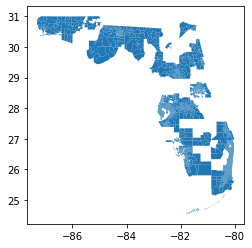

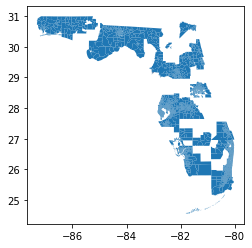

In [77]:
#Mapping the validated precincts of these
pdv_shapes_elections_and_shapes.plot()

In [ ]:
#Mapping the VEST file precincts of these
vest_shapes_elections_and_shapes.plot()

In [ ]:
#Mapping the difference between the two
shp_difference = gp.overlay(pdv_shapes_elections_and_shapes, vest_shapes_elections_and_shapes, how='symmetric_difference')
shp_difference.plot()

#### Precincts not matched to election results from the sourcefiles

In [60]:
second_check_left = merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only")]['geometry_x']
second_check_right = merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only")]['geometry_y']

pdv_shapes_just_shapes = gp.GeoDataFrame(second_check_left, geometry='geometry_x')
vest_shapes_just_shapes = gp.GeoDataFrame(second_check_right, geometry='geometry_y')

pdv_shapes_just_shapes.crs = vest_shapes_just_shapes.crs

In [65]:
print(pdv_shapes_just_shapes.geom_almost_equals(vest_shapes_just_shapes,decimal=1).value_counts())

False    74
True     12
dtype: int64


Problem is that there is only one PAL00NP from the source files and ~67 (w/ different geometries) from the VEST file, so the error is duplicating itself, as the one PAL00NP from the sourcefiles is matched to all 67 and cannot possibly be equal to all of them.

According to VEST, there are 0 votes totals in these, so seems like an issue of where these areas are added to and VEST wanting a shapefile for the entire state.

PAL00NP    67
DAD0778     1
BROC007     1
OSC0520     1
DUV1306     1
           ..
DAD0343     1
PAL1234     1
HIG0016     1
MRN3750     1
HIL0407     1
Name: Pct_std, Length: 6007, dtype: int64
     Pct_std                                           geometry
871  PAL00NP  MULTIPOLYGON (((-80.20551 26.53499, -80.21901 ...
0.0


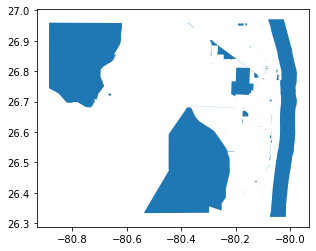

In [75]:
#Print out all the "PAL00NP" unique IDs
#print(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only") & (merged_data_everything["Pct_std"]=="PAL00NP")].head())

#Show there are 67 "PAL00NP" in the VEST file
print(vest_fl["Pct_std"].value_counts())

#Confirm there is only one "PAL00NP" from the sourcefiles
print(shapefiles_palm[shapefiles_palm["Pct_std"]=="PAL00NP"])

#Plot all of these using the VEST geometry
#Comparing to map, looks like these are uninhabited areas
vest_pal00np_check = gp.GeoDataFrame(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only") & (merged_data_everything["Pct_std"]=="PAL00NP")], geometry='geometry_y')
vest_pal00np_check.plot()

#Confirm that these precincts are don't have votes in the VEST file
print(sum(merged_data_everything[(merged_data_everything["main_merge"]=="both") & (merged_data_everything["_merge"]=="right_only") & (merged_data_everything["Pct_std"]=="PAL00NP")]['G18USSDNEL_y']))

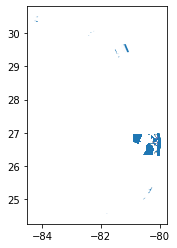

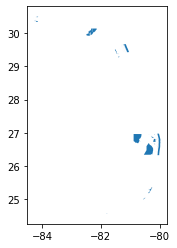

In [63]:
pdv_shapes_just_shapes.plot()
vest_shapes_just_shapes.plot()

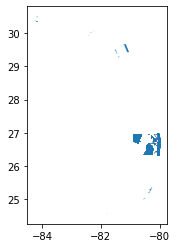

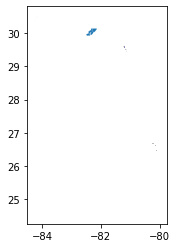

In [64]:
#Plot where these intersect
shp_intersection = gp.overlay(pdv_shapes_just_shapes, vest_shapes_just_shapes, how='intersection')
shp_intersection.plot()

In [ ]:
#Plot where these are different
shp_difference = gp.overlay(pdv_shapes_just_shapes, vest_shapes_just_shapes, how='symmetric_difference')
shp_difference.plot()

## Validation Summary

#### Overview

After creating a file from original sources and matching to VEST:

- There are 260 precincts that only appear in the sourcefiles
- There are 4 precincts that only appear in the vest file
- There are 6069 precincts that were matched between the two files

Note: "matched" just means the unique ID matched. Since we were not able to recreate election results and a precinct shapefile for every precinct, some of the 6069 precincts that matched will just have either election data or a shapefile from original sourcefiles.  

#### The 264 precincts that didn't match:

- For our purposes, we did not try to match either the 260 precincts that only appear in the sourcefiles or the 4 precincts that only appear in the VEST file.

#### The 6069 precincts that matched:

- 1271 rows where there is a match but no shapefile data available
- 101 rows where we couldn't find the shapefile in a county where it was available
- 86 rows where there is a match, but no election results
- 4611 rows where there is a match and both shapefile and election data

#### Checking Election Results
  
For the 5983 precincts where election results were matched:
- 25 of these precincts had some differences
- 5958 were exactly the same

Also checked the totals of the FL state data and the VEST file:
- None of the totals for a particular race were exactly equal
- However, the largest difference was .015%

#### Checking Shapefiles

For the 4697 precincts where shapefiles were matched:
- 3992 of the precincts were the same (to one decimal)
- 705 of the precincts were different

- Note: Of these 705, there is one precinct ID from the VEST file "PAL00NP" that occurs 67 times with different shapefiles and only one precinct from the source files with that ID, which explains at least 66 of the non-matches. For the other ~640 non-matches, the difference is plotted above.